## Project 1
- Mike Ames 
- amesam@wfu.edu
- 17May2020


### Load Packages
-------



In [1]:
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% }</style>"))
# ------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# -- first sklearn module, split training and test
from sklearn.model_selection import train_test_split

# -- need this to render charts in notebook -- 
%matplotlib inline

## Tasks 
### Part 1
1. Stage data
2. Clean up column names 
3. Describe data 
4. Explore likely predictors  

### Part 2.
5. Partition into 75/25 split 
6. Write a rule to predict likely targets 
7. Evaluate  

### Part 3.  
8. Write up your thoughts. 

# Part 1. 
## 1. Stage 
----- 
import our dataset into a pandas dataframe


In [2]:
df = pd.read_csv("./data/adult.csv")
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


## 2.  Clean up Column Names

*It's just not fun dealing with ill-formed columns*

- remove leading and trailing characters
- replace spaces with underscores _ 
- change case to lower case
- remove various special characters

In [64]:
df.columns = ( df.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace('-', '_')
    .str.replace('(', '')
    .str.replace(')', '')
    .str.replace('?', '')
    .str.replace('\'', '') # notice the backslash \ this is an escape character
)
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational_num',
       'marital_status', 'occupation', 'relationship', 'race', 'gender',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income'],
      dtype='object')

## 3. Describe data
### Check Target
-----
always start by understanding your target value 


In [7]:
df['income'].value_counts()

<=50K    37155
>50K     11687
Name: income, dtype: int64

### Describe 
---------
Always take a look at your data to see what you are dealing with 

In [65]:
df.describe(include='all').T.sort_values('unique')

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,48842,2,Male,32650,NaN,NaN,NaN,NaN,NaN,NaN,NaN
income,48842,2,<=50K,37155,NaN,NaN,NaN,NaN,NaN,NaN,NaN
race,48842,5,White,41762,NaN,NaN,NaN,NaN,NaN,NaN,NaN
relationship,48842,6,Husband,19716,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital_status,48842,7,Married-civ-spouse,22379,NaN,NaN,NaN,NaN,NaN,NaN,NaN
workclass,48842,9,Private,33906,NaN,NaN,NaN,NaN,NaN,NaN,NaN
occupation,48842,15,Prof-specialty,6172,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,48842,16,HS-grad,15784,NaN,NaN,NaN,NaN,NaN,NaN,NaN
native_country,48842,42,United-States,43832,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,48842,NaN,NaN,NaN,38.6436,13.7105,17,28,37,48,90


#### Check out Nulls 
----
Null values can be interesting but you have to deal with them when we get to building models. step 1 is to identify your problem areas. step 2 would be to figure out if there is any predictive power in the nulls, step 3. would be handle them. forturnately we are just going to deal with identifyin if we have any nulls. 

In [19]:
# -- count nulls by column -- 
df.isnull().sum(axis = 0)

age                0
workclass          0
fnlwgt             0
education          0
educational_num    0
marital_status     0
occupation         0
relationship       0
race               0
gender             0
capital_gain       0
capital_loss       0
hours_per_week     0
native_country     0
income             0
dtype: int64

## 4. Explore likely predictors
### Make Histograms, Crosstabs and Barcharts 


----- 

We are looking to identify variables, split points and conditions that are likely useful to predict our target. 

Here is my basic recipe. 
1. Use histograms on NUMERIC varaibles, mess with the number of bins to make a more interesting chart. 
2. Use crosstab to create a table of frequencies for CATEGORICAL variables, you may want to normalize or not, i do both. 
    - first create a cross tab column by target, use reset_index() to return a dataframe instead of a crosstab 
    - second plot using a BAR chart(s) i typically usae one for each target variable 
    - if you want to get fancy you can use the bottom option for one of your 
histograms work on numbers, 
barcharts are useful for categorical frequencies 


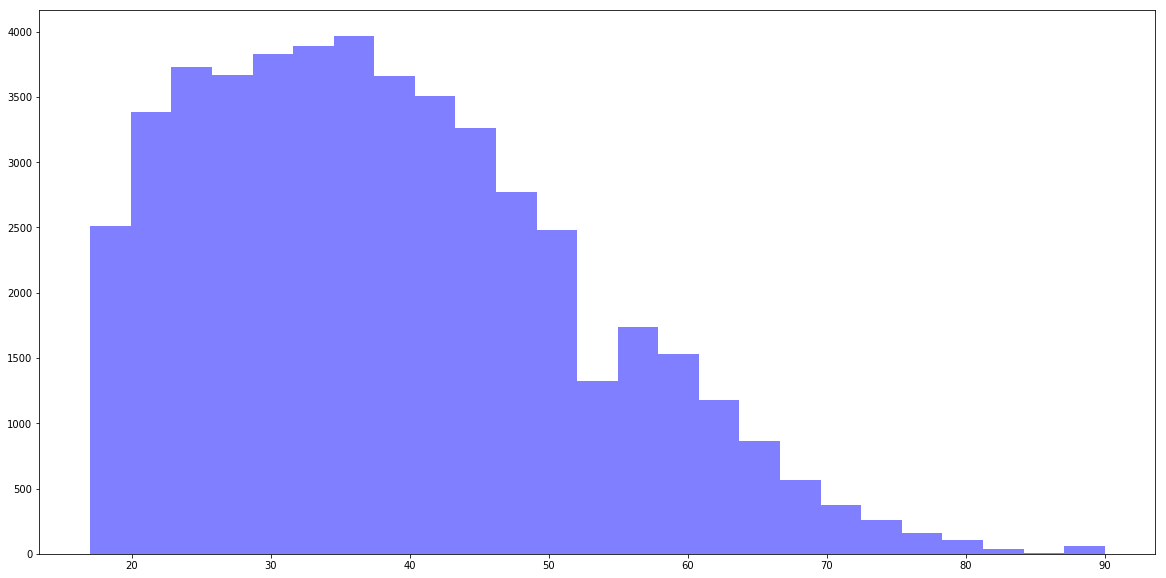

In [28]:
plt.figure(figsize=(20,10))
# -- simply change the bin size to make the chart look better --

plt.hist(df['age'], 25, facecolor='blue', alpha=0.5)
plt.show()

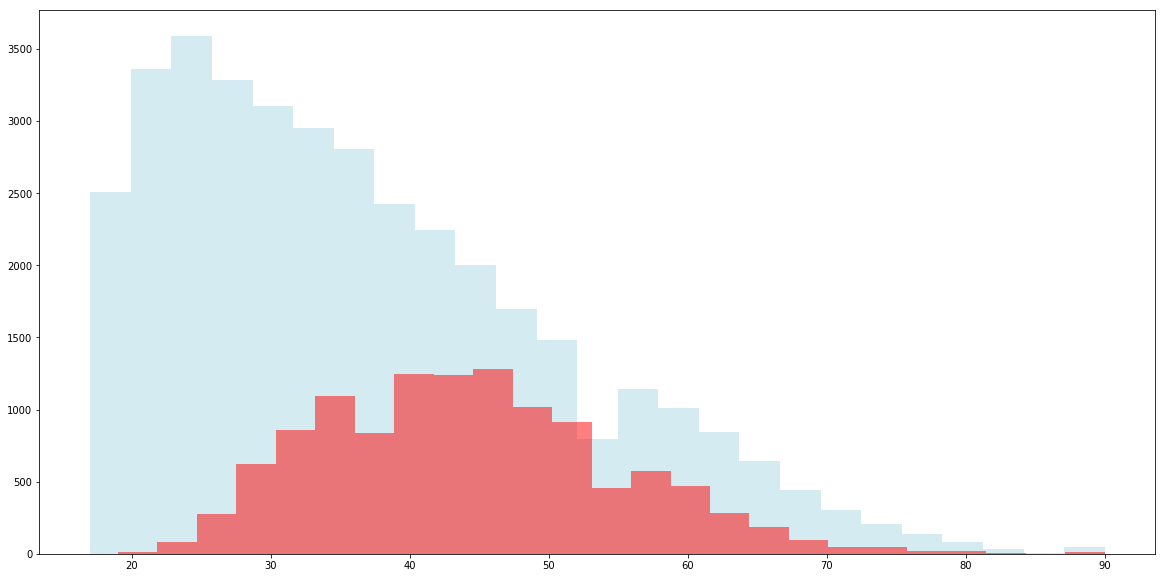

In [30]:
plt.figure(figsize=(20,10))

# -- divide my data into two datasets by target variable 
lt50 = df.loc[df['income']== "<=50K"]
gt50 = df.loc[df['income']== ">50K"]

# -- simply change the bin size to make the chart look better --
plt.hist(lt50['age'], 25, facecolor='lightblue', alpha=0.5)
plt.hist(gt50['age'], 25, facecolor='red', alpha=0.5)

plt.show()

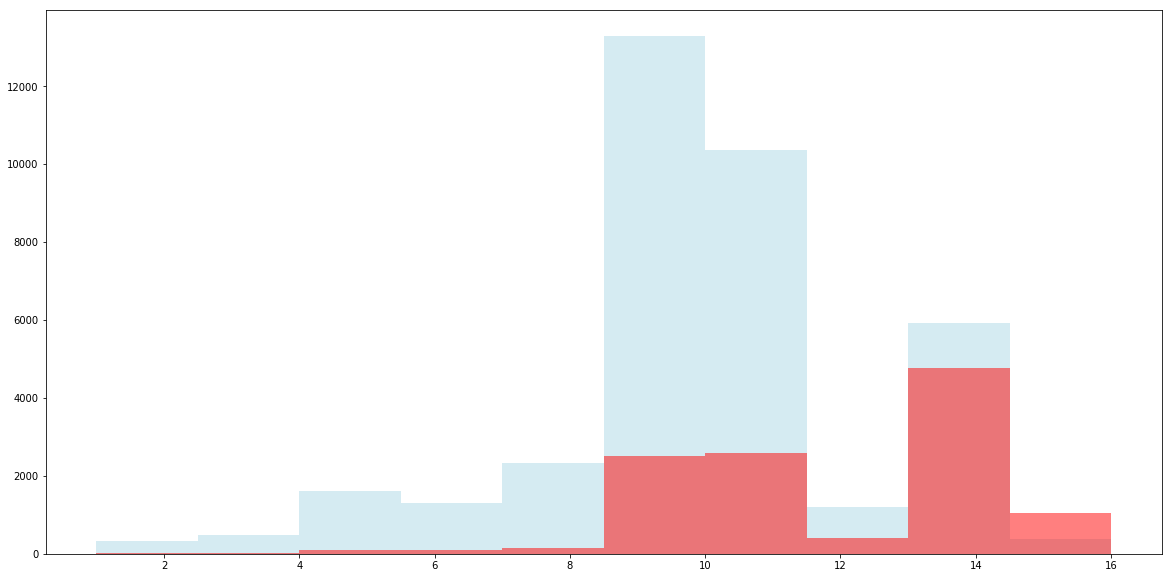

In [33]:
plt.figure(figsize=(20,10))

# -- simply change the bin size to make the chart look better --
plt.hist(lt50['educational_num'], 10, facecolor='lightblue', alpha=0.5)
plt.hist(gt50['educational_num'], 10, facecolor='red', alpha=0.5)

plt.show()

### OK what about Categorical Data? 

-----

first i use a crosstab to create a new table of the column by the target. you can read about crosstabs here 

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html

Can you understand the difference when we look at percentages rather than counts? what does this tell us about identifying high earners? 

In [53]:
# -- normalize index converts to row percetages 
ctab = pd.crosstab(df['relationship'], df['income'], normalize="index").reset_index()
ctab

income,relationship,<=50K,>50K
0,Husband,0.551329,0.448671
1,Not-in-family,0.898593,0.101407
2,Other-relative,0.965471,0.034529
3,Own-child,0.985358,0.014642
4,Unmarried,0.939707,0.060293
5,Wife,0.531103,0.468897


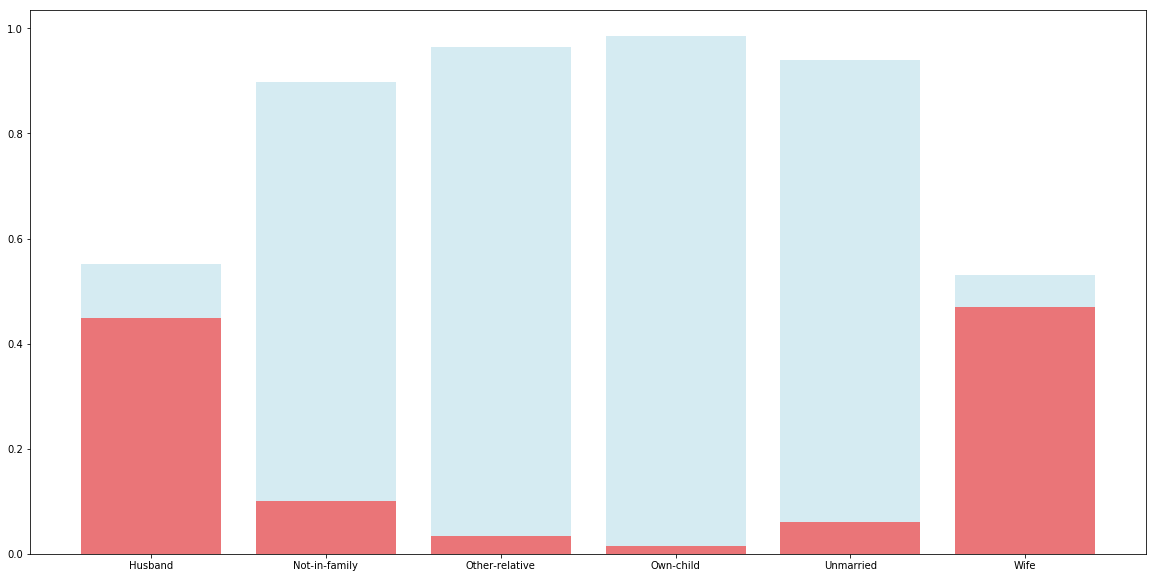

In [54]:
plt.figure(figsize=(20,10))
# -- simply change the bin size
plt.bar(ctab['relationship'], ctab['<=50K'], facecolor='lightblue', alpha=0.5)
plt.bar(ctab['relationship'], ctab['>50K'], facecolor='red', alpha=0.5)
plt.show()

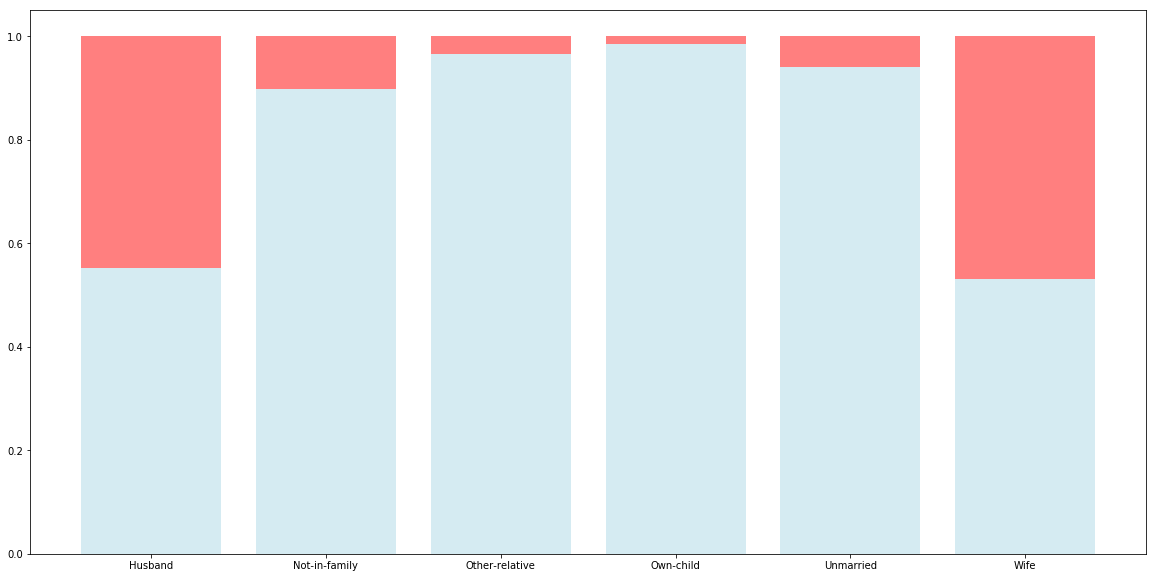

In [55]:
plt.figure(figsize=(20,10))
# -- check out bottom 
plt.bar(ctab['relationship'], ctab['<=50K'], facecolor='lightblue', alpha=0.5)
plt.bar(ctab['relationship'], ctab['>50K'], bottom=ctab['<=50K'], facecolor='red', alpha=0.5)
plt.show()

In [56]:
# -- without normalization you just get a frequency about the categories, which is usefull too. 
ctab = pd.crosstab(df['relationship'], df['income']).reset_index()
ctab

income,relationship,<=50K,>50K
0,Husband,10870,8846
1,Not-in-family,11307,1276
2,Other-relative,1454,52
3,Own-child,7470,111
4,Unmarried,4816,309
5,Wife,1238,1093


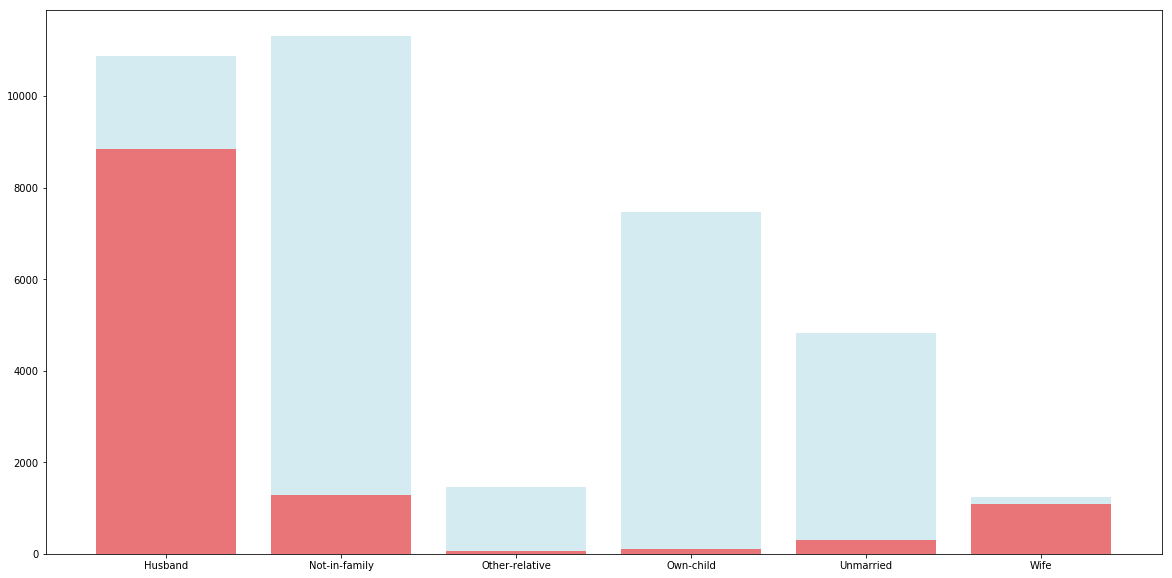

In [57]:
plt.figure(figsize=(20,10))
plt.bar(ctab['relationship'],ctab['<=50K'], facecolor='lightblue', alpha=0.5)
plt.bar(ctab['relationship'],ctab['>50K'], facecolor='red', alpha=0.5)

plt.show()

In [62]:
# -- normalize index converts to row percetages 
ctab = pd.crosstab(df['education'], df['income'], normalize="index").reset_index().sort_values('<=50K',ascending=False )
ctab

income,education,<=50K,>50K
13,Preschool,0.987952,0.012048
3,1st-4th,0.967611,0.032389
1,11th,0.949227,0.050773
4,5th-6th,0.946955,0.053045
6,9th,0.945767,0.054233
0,10th,0.937365,0.062635
5,7th-8th,0.935079,0.064921
2,12th,0.926941,0.073059
11,HS-grad,0.841422,0.158578
15,Some-college,0.810351,0.189649


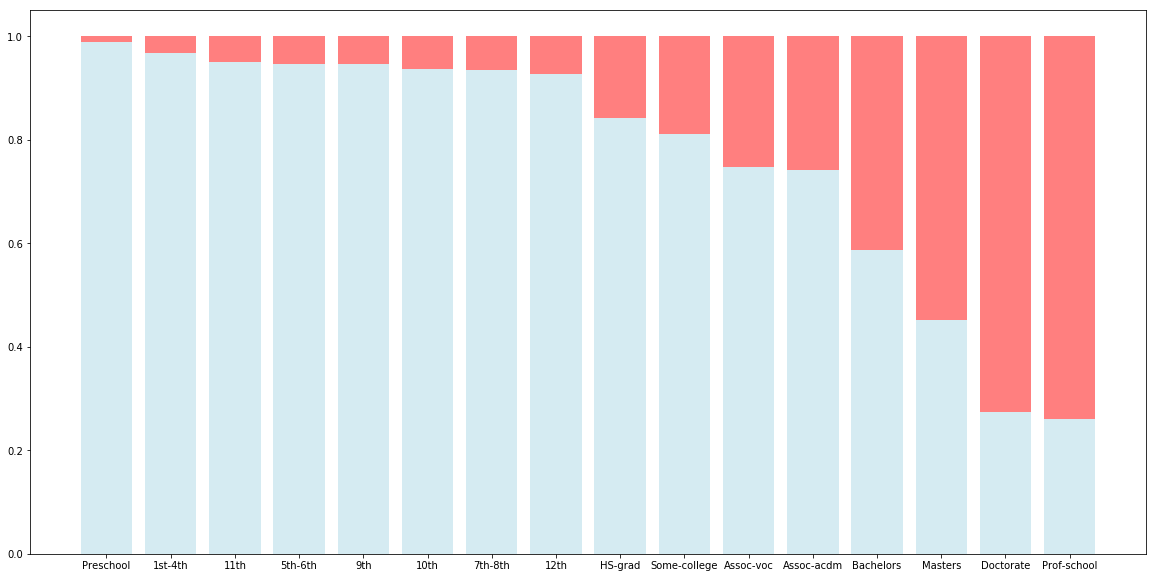

In [63]:
plt.figure(figsize=(20,10))
# -- check out bottom 
plt.bar(ctab['education'], ctab['<=50K'], facecolor='lightblue', alpha=0.5)
plt.bar(ctab['education'], ctab['>50K'], bottom=ctab['<=50K'], facecolor='red', alpha=0.5)
plt.show()

## Part 2.
### 5. Partition into 75/25 split
-----
Sklearn is our main pakage, we imported **train_test_split** from the model selection module. Why do we need to split the data? well we do it so that we are making predictions on an out-of-sample data, meaning will our prediction generalize to new and unseen data? it isn't fair to evaluate our prediction if it's seen the data before right? i mean you wouldn't go to your psychic and tell them exactly what you want to hear before they do your the reading?

So what percentage to use? the general rule of thumb is a 70/30 or 75/25 training test split. you'll "train" your model on 70% of the data and evaluate it on 30%. 




In [76]:
train, test = train_test_split(df,test_size=0.30)
print("train pct: {:2.2%}".format(train.shape[0]/df.shape[0]))
print("test  pct: {:2.2%}".format(test.shape[0]/df.shape[0]))


train pct: 70.00%
test  pct: 30.00%


## 6. Write a rule to predict likely targets
-----
based on our exploratory analysis above we can see that age, education, and relationship are probalby good predictors of income. Here i'm going to create a rule based on the following logic 

- age >= 40 
- education in ('Bachelors', 'Masters', 'Doctorate', 'Prof-school')
- relationship in ('Husband', 'Wife')

To do this. 
1. make a new column **income_pred** default it to <=50k, our majority class 
2. write rules to update **income_pred** to equal >50k 
3. I like confusion matricies they help you know how well you are doing, predicting the target. 


Training confusion Matrix
Predicted  <=50K   >50K
Actual                 
<=50K      10100  15875
>50K         189   8025


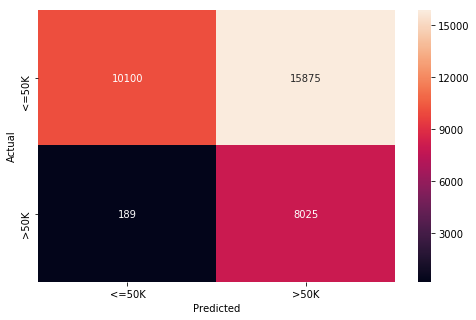

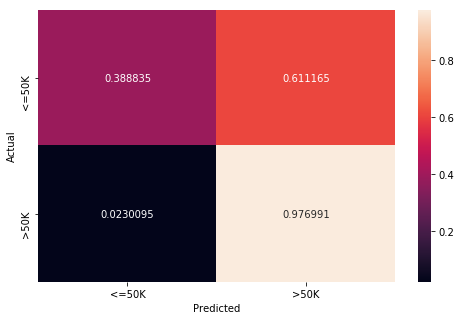

In [128]:
# -- default the predicted target 
train.loc[:,'income_pred'] = '<=50K'
# -- update where rules are met 
train.loc[train['age'] >= 40, 'income_pred' ] = '>50K'
train.loc[train['education'].isin(['Bachelors', 'Masters', 'Doctorate', 'Prof-school']), 'income_pred' ] = '>50K'
train.loc[train['relationship'].isin(['Husband', 'Wife']),  'income_pred' ] = '>50K'


print("Training confusion Matrix")
confusion_matrix = pd.crosstab(train['income'], train['income_pred'],  rownames=['Actual'], colnames=['Predicted'])
confusion_matrix_pct = pd.crosstab(train['income'], train['income_pred'], normalize="index", rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

plt.figure(figsize=(8,5))
sns.heatmap(confusion_matrix, annot=True, fmt='g')
plt.show()

plt.figure(figsize=(8,5))
sns.heatmap(confusion_matrix_pct, annot=True, fmt='g')
plt.show()

Test confusion Matrix
Predicted  <=50K  >50K
Actual                
<=50K       4439  6741
>50K          91  3382


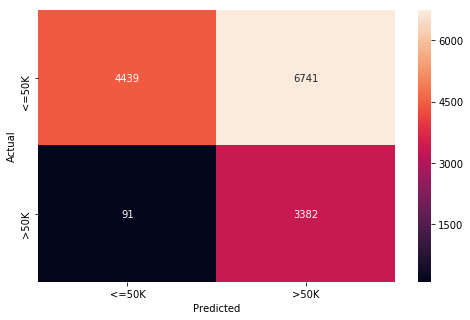

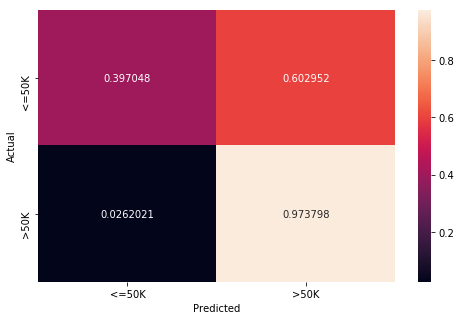

In [129]:
# -- repeat with the test dataset 
test.loc[:,'income_pred'] = '<=50K'
# -- update where rules are met 
test.loc[test['age'] >= 40, 'income_pred' ] = '>50K'
test.loc[test['education'].isin(['Bachelors', 'Masters', 'Doctorate', 'Prof-school']), 'income_pred' ] = '>50K'
test.loc[test['relationship'].isin(['Husband', 'Wife']),  'income_pred' ] = '>50K'

print("Test confusion Matrix")
confusion_matrix = pd.crosstab(test['income'], test['income_pred'],  rownames=['Actual'], colnames=['Predicted'])
confusion_matrix_pct = pd.crosstab(test['income'], test['income_pred'], normalize="index", rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

plt.figure(figsize=(8,5))
sns.heatmap(confusion_matrix, annot=True, fmt='g')
plt.show()

plt.figure(figsize=(8,5))
sns.heatmap(confusion_matrix_pct, annot=True, fmt='g')
plt.show()

## 7. Evaluate

How accurate were we? Accuracy is one metric for evaluating classification models. Informally, accuracy is the fraction of predictions our model got right. 
Formally, accuracy has the following definition:

    accuracy = number of correct predictions / all predictions 
    
    
We always want to understand if we did nothing, how accurate were we? and then compare how accurate were we with our predictions. 

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html



In [98]:
from sklearn.metrics import accuracy_score
### Default Accuracy, i.e. do nothing predict everyone as <50K, is the same as saying what % of <50K 
accuracy_default = train['income'].value_counts(normalize='True')[0]
accuracy_train = accuracy_score(train['income'], train['income_pred'])
accuracy_test = accuracy_score(test['income'], test['income_pred'])
print("Default Accuracy : {:2.2%}".format(accuracy_default))
print("Train Accuracy   : {:2.2%}".format(accuracy_train))
print("Test Accuracy    : {:2.2%}".format(accuracy_test))

Default Accuracy : 75.97%
Train Accuracy   : 53.01%
Test Accuracy    : 53.37%


## 8. Writeup 
----- 
i'm not looking for anything long, just a short write up on what you did, what you thought was interesing about the data, how your rules performed, what can you infer about accuracy as a measure of performance vs. a confusion matrix? is Accuracy a good measure of classifier performance?  